# Lab 4 Report

Prepared by Zech Wolf

## 1. Loading the data

### 1.1 Read and clean NAs

In [34]:
import pandas as pd

df = pd.read_csv("datasets/acs2017_census_tract_data.csv")

In [35]:
df.dropna(inplace=True)

In [36]:
from sklearn.preprocessing import LabelEncoder

#Encode the strings as ints with a label encoder
le = LabelEncoder()
df.State = le.fit_transform(df.State)
df.County = le.fit_transform(df.County)

I decided to keep the County feature in the dataset. Each observation in the datset is a census tract, which is a subdivision of a county. This means that multiple samples will belong to the same county. As such, tracts in the same county are likely physically close to one another, and could be subject to similar laws and regulations. So the county could be a valuable piece of information for classification.

### 1.2 Quantizing child poverty

The target is calculated using the quartiles of the ChildPoverty variable, ensuring the classes are balanced as much as possible

In [37]:
import numpy as np

#df["target"] = pd.qcut(x=df.ChildPoverty, q=4, labels=False)
df["target"] = pd.cut(x=df.ChildPoverty, bins=[-1,10,20,60,100], labels=False)

In [38]:
#Check the balance of the target
np.bincount(df.target)

array([25822, 15866, 27875,  3155])

### 1.3 Train-test split

In [39]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["ChildPoverty", "target", "TractId"]) #tract id is just a unique identifier, so we don't need it
y = df["target"] #keep these as pandas objects to make manipulation easier later on

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, train_size=0.8) #split as numpy arrays

It is important that the classes are balanced in both the training and testing sets. Since we are assuming that classification is equally important for all classes in the dataset, a balanced training set means that a classifier has a roughly equal number of instances from each class to train on and learn how to identify. A balanced training set means that the accuracy of the predictions on the training set is actually representative of the performance of the model, according to the criteria that the classes are equally important.

No. change to common sense thresholds. train should be balanced but test should not.

In [40]:
np.bincount(y_train)

array([20735, 12680, 22248,  2511])

## 2. Preprocessing and Initial Modeling

### 2.1 Two-Layer Perceptron Implementation

This implementation uses:
* Binary cross entropy
* Mini batching
* Glorot and He weight initialization
* Vectorized gradient computation

In [41]:
from scipy.special import expit

class TLPBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
        return onehot

    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

In [42]:
import sys
class TwoLayerPerceptron(TLPBase):
    def __init__(self, shuffle=True, minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)

    def fit(self, X, y, print_progress=0):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        self.cost_ = []
        for k in range(self.epochs):

            if print_progress>0 and (k+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (k+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                # shuffle the data so batches ar different
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            # use numpy split to split into equal sized batches 
            # num batches == self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.b1,
                                                       self.b2
                                                      )
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1, W2=self.W2)

                self.W1 -= self.eta * gradW1
                self.W2 -= self.eta * gradW2
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2

            self.cost_.append(mini_cost)

### 2.2 Testing procedure

I define a function to fit a neural network on the training data and predict on the testing set. The accuracy is printed alongside the loss curve.

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

sns.set_theme()

def plot_cost(nn):
    cost_avg = np.apply_along_axis(np.mean, 1, nn.cost_)
    sns.lineplot(x=range(len(cost_avg)), y=cost_avg)
    plt.xlabel("Epoch")
    plt.ylabel("Cost")
    plt.show()

def eval_nn(nn):
    nn.fit(X_train, y_train)
    y_pred = nn.predict(X_test)
    plot_cost(nn)
    print(f"The network achieved an accuracy of: {accuracy_score(y_test, y_pred)}")

### 2.3 Performance on unprocessed data

In [18]:
tlp = TwoLayerPerceptron(C=.01, epochs=50, minibatches=len(X_train)/10) #use the same object and retrain on each dataset

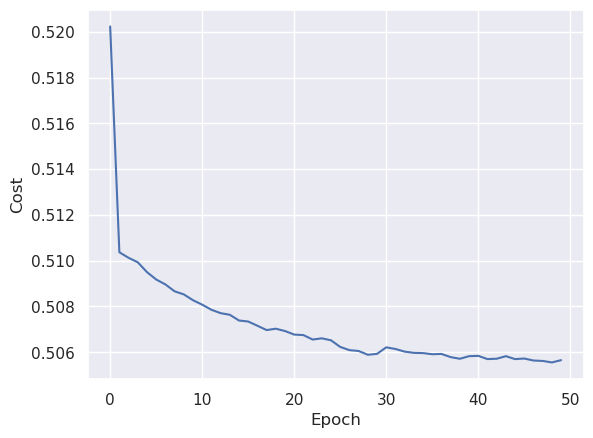

The network achieved an accuracy of: 0.3873074807480748


In [17]:
eval_nn(tlp)

### 2.4 Performance on normalized continuous features

In [22]:
from sklearn.preprocessing import StandardScaler

#The only non continuous features are state and county, col 0 and 1
scaler = StandardScaler()
X_train[:,2:] = scaler.fit_transform(X_train[:,2:])
X_test[:,2:] = scaler.fit_transform(X_test[:,2:])

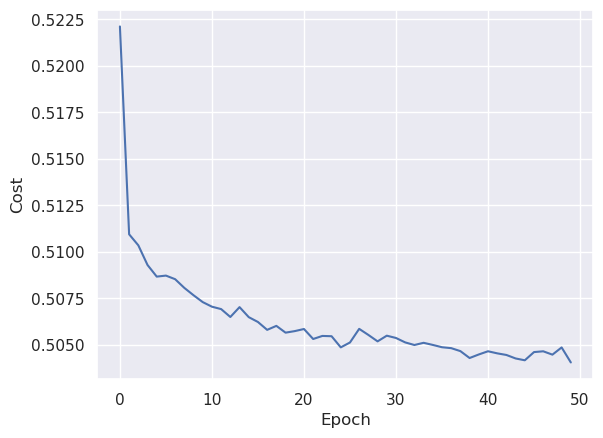

The network achieved an accuracy of: 0.3990649064906491


In [26]:
#Test the network
eval_nn(tlp)

### 2.5 Performance on OHE and normalized features

In [49]:
states_tr = pd.get_dummies(X_train[:,0]).values
states_tst = pd.get_dummies(X_test[:,0]).values
counties_tr = pd.get_dummies(X_train[:,1]).values
counties_tst = pd.get_dummies(X_test[:,1]).values

X_train = np.concatenate()